In [1]:
import torch
import torchaudio
import os
import pandas as pd
import matplotlib.pyplot as plt
import torchaudio.transforms as AT
import torchaudio.functional as F
import torchvision.transforms.v2 as VT
import random
import numpy as np
from IPython.display import Audio, display

In [2]:
data_dir = '/local/202510_csci581_project/project_data/task2/'
train_dir = data_dir + 'train/'
dev_dir = data_dir + 'dev/'


In [3]:
train_wav = [f for f in os.listdir(train_dir) if f.endswith(".wav")]
train_spkid_txt = [f for f in os.listdir(train_dir) if f.endswith(".spkid.txt")]
train_dialect_txt = [f for f in os.listdir(train_dir) if f.endswith(".dialect.txt")]

dev_wav = [f for f in os.listdir(dev_dir) if f.endswith(".wav")]
dev_spkid_txt = [f for f in os.listdir(dev_dir) if f.endswith(".spkid.txt")]
dev_dialect_txt = [f for f in os.listdir(dev_dir) if f.endswith(".dialect.txt")]
 

In [4]:

# add speakerIDs and dialectIDs to dataframe
def add_spkrid_dialect(df, dir, spkrid_txt_list, dialect_txt_list):
    df["spkrid"] = None
    df["dialect"] = None
    print("Getting IDs...")
    for f in spkrid_txt_list:
        id = f.removesuffix(".spkrid.txt")
        id = id.removeprefix("file")
        with open(dir + f, 'r') as file:
            spkrid = file.readline().strip()
            df.loc[df['id'] == id, 'spkrid'] = spkrid
    for f in dialect_txt_list:
        id = f.removesuffix(".dialect.txt")
        id = id.removeprefix("file")
        with open(dir + f, 'r') as file:
            dialect = file.readline().strip()
            df.loc[df['id'] == id, 'dialect'] = dialect

In [5]:
f = random.choice(train_wav)
f_path = os.path.join(train_dir, f)
metadata = torchaudio.info(f_path)
print(f'Filename: {f}, ', 
        f'Num frames: {metadata.num_frames}, ' 
        f'Sample rate: {metadata.sample_rate} '
        f'Num channels: {metadata.num_channels}, '
        f'Duration(s): {metadata.num_frames / metadata.sample_rate}')

Filename: file3627.wav,  Num frames: 49562, Sample rate: 16000 Num channels: 1, Duration(s): 3.097625


In [6]:
# get number associated with wav file e.g. file12.wav --> 12
def add_id(df, wav_list):
    id_list = [f[4:-4] for f in wav_list] 
    df["id"] = id_list 
    return df

In [7]:
# add speakerIDs and dialectIDs to dataframe
def add_spkid_dialect(df, dir, spkid_txt_list, dialect_txt_list):
    df["spkid"] = None
    df["dialect"] = None
    print("Getting IDs...")
    for f in spkid_txt_list:
        id = f.removesuffix(".spkid.txt")
        id = id.removeprefix("file")
        with open(dir + f, 'r') as file:
            spkid = file.readline().strip()
            df.loc[df['id'] == id, 'spkid'] = spkid
    for f in dialect_txt_list:
        id = f.removesuffix(".dialect.txt")
        id = id.removeprefix("file")
        with open(dir + f, 'r') as file:
            dialect = file.readline().strip()
            df.loc[df['id'] == id, 'dialect'] = dialect

In [8]:
# add torchaudio metadata to dataframe
def add_metadata(df, dir, wav_list):
    df['num_frames'] = None
    df['duration'] = None
    print("Getting torchaudio metadata...")
    total = len(wav_list)
    complete = 0
    for f in wav_list:
        metadata = torchaudio.info(dir + f)
        seconds = metadata.num_frames / metadata.sample_rate 
        ID = f[4:-4]
        df.loc[df['id'] == ID, 'num_frames'] = metadata.num_frames
        df.loc[df['id'] == ID, 'duration'] = seconds
        complete += 1
        print(f'{complete}/{total}', end='\r')

In [9]:
df = pd.DataFrame()
add_id(df, train_wav)
add_spkid_dialect(df, train_dir, train_spkid_txt, train_dialect_txt)
add_metadata(df, train_dir, train_wav)
df

Getting IDs...
Getting torchaudio metadata...


,id,spkid,dialect,num_frames,duration
0,3193,257,3,51712,3.232
1,1544,159,2,43316,2.70725
2,1317,135,1,50484,3.15525
3,6270,195,0,60314,3.769625
4,5539,331,4,42087,2.630438
...,...,...,...,...,...
3725,5022,292,5,34919,2.182437
3726,2244,179,7,49357,3.084812
3727,5282,486,2,37274,2.329625
3728,4022,224,3,36660,2.29125


In [10]:
print(len(train_wav))

3730


Max duration 7.79
Min duration 0.92
Mean duration 3.05
Std-dev duration 0.86


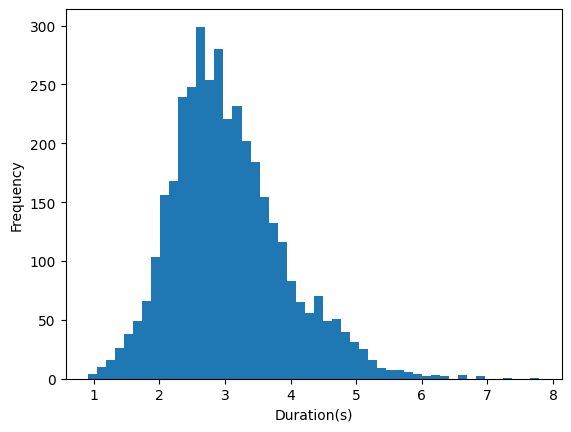

In [11]:
# Mean duration
min_dur = df['duration'].min()
max_dur = df['duration'].max()
mean_dur = df['duration'].mean()
std_dur = df['duration'].std()
dur = df['duration']
dur.plot(kind='hist', bins=50, xlabel='Duration(s)')
print(f'Max duration {max_dur:.2f}')
print(f'Min duration {min_dur:.2f}')
print(f'Mean duration {mean_dur:.2f}')
print(f'Std-dev duration {std_dur:.2f}')

In [12]:
dialect_agg = df.groupby(['dialect'], as_index=False).agg({'duration':['mean','std']})
print(dialect_agg)

  dialect  duration          
               mean       std
0       0  2.977799  0.877030
1       1  2.986447  0.806751
2       2  2.987575  0.768501
3       3  3.100374  0.900089
4       4  3.274196  0.984050
5       5  3.167139  0.905830
6       6  2.993426  0.812409
7       7  2.895207  0.847528


In [13]:
df_dev = pd.DataFrame()
add_id(df_dev, dev_wav)
add_spkid_dialect(df_dev, dev_dir, dev_spkid_txt, dev_dialect_txt)

dialect_count_train = df.groupby('dialect').agg(count=('dialect', 'count'))
dialect_count_dev = df_dev.groupby('dialect').agg(count=('dialect', 'count'))

dialect_count = dialect_count_train.join(other=dialect_count_dev, on='dialect', 
                                         lsuffix='_train', rsuffix='_dev')
dialect_count

Getting IDs...


,count_train,count_dev
dialect,,
0,350,30
1,700,60
2,640,120
3,470,210
4,550,150
5,260,90
6,580,190
7,180,40


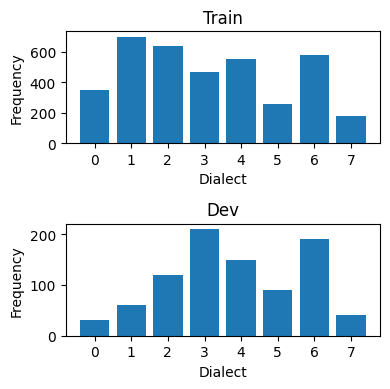

In [41]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(4,4))
ax1.bar(range(8), dialect_count['count_train'], tick_label=(range(8)))
ax1.set_title('Train')
ax1.set_xlabel('Dialect')
ax1.set_ylabel('Frequency')
ax2.bar(range(8), dialect_count['count_dev'], tick_label=(range(8)))
ax2.set_title('Dev')
ax2.set_xlabel('Dialect')
ax2.set_ylabel('Frequency')
plt.tight_layout()

In [15]:
pd.set_option('display.max_rows', None)
speaker_count_train = df.groupby('spkid').agg(count=('spkid', 'count'))
speaker_count_dev = df_dev.groupby('spkid').agg(count=('spkid', 'count'))
# speaker_count_train = speaker_count_train.reset_index()
# speaker_count_dev = speaker_count_dev.reset_index()


speaker_count = speaker_count_dev.join(other=speaker_count_train, on='spkid', how='outer', 
                                         lsuffix='_dev', rsuffix='_train')
speaker_count = speaker_count.apply(pd.to_numeric)
speaker_count.sort_values(by='spkid', inplace=True, ascending=True)
print(speaker_count)

     spkid  count_dev  count_train
NaN      0        NaN         10.0
NaN      1        NaN         10.0
NaN      3        NaN         10.0
NaN      4        NaN         10.0
NaN      5        NaN         10.0
NaN      6        NaN         10.0
NaN      7        NaN         10.0
NaN      8        NaN         10.0
NaN     11        NaN         10.0
NaN     12        NaN         10.0
NaN     15        NaN         10.0
NaN     17        NaN         10.0
NaN     18        NaN         10.0
NaN     19        NaN         10.0
21      21       10.0          NaN
22      22       10.0          NaN
NaN     23        NaN         10.0
NaN     24        NaN         10.0
NaN     25        NaN         10.0
26      26       10.0          NaN
30      30       10.0          NaN
NaN     31        NaN         10.0
NaN     34        NaN         10.0
35      35       10.0          NaN
NaN     36        NaN         10.0
NaN     37        NaN         10.0
NaN     40        NaN         10.0
NaN     41        Na

In [16]:
# Load a random wav file
f = random.choice(train_wav)
filepath = os.path.join(train_dir, f)
    
waveform, sample_rate = torchaudio.load(filepath, normalize=True)

print(f)
print(waveform.shape)
print("Frames: ", torchaudio.info(filepath).num_frames)

file2557.wav
torch.Size([1, 50074])
Frames:  50074


Text(0.5, 0, 'frames')

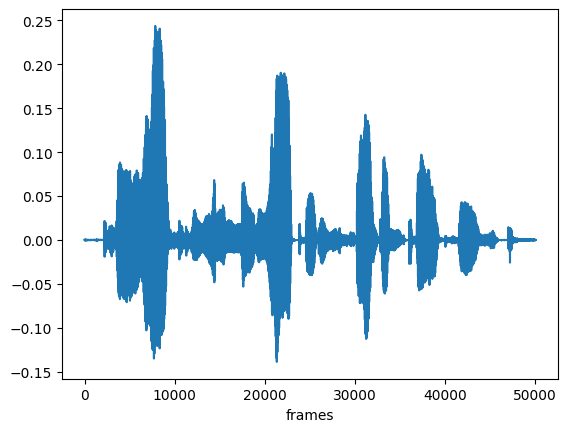

In [17]:
# Visualize waveform
plt.plot(waveform[0])
plt.xlabel('frames')

In [18]:
n_mels = 128

mel_spectrogram = AT.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=600,
    n_mels=n_mels,
    win_length=400, # 25ms
    hop_length=160, #10ms
    f_max=sample_rate / 2.0
)
melspec = mel_spectrogram(waveform)

In [19]:
transform = VT.Compose([
    torchaudio.functional.preemphasis, 
    mel_spectrogram,
    AT.AmplitudeToDB(top_db=80), 
    ]
)

In [20]:
length = []
for f in train_wav:
    filepath = os.path.join(train_dir, f)
    waveform, sample_rate = torchaudio.load(filepath)
    mel = transform(waveform)
    length.append(mel.shape[-1])

In [21]:
print("mean: ", np.mean(length))
print("std:", np.std(length))

mean:  305.70938337801607
std: 86.35264839680696


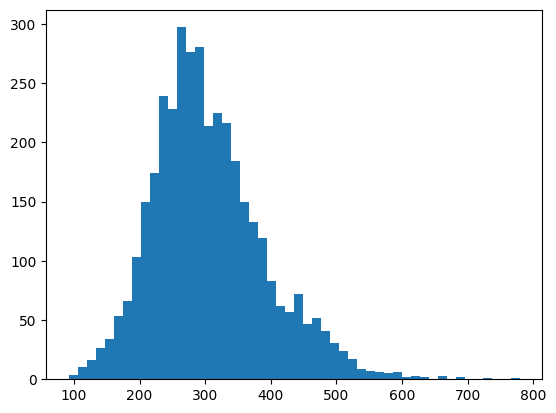

In [22]:
# Mean length of mel spectrogram
plt.hist(length, bins=50)
plt.show()

In [23]:
waveform, sample_rate = torchaudio.load(filepath, normalize=True)
melspec_db = transform(waveform)
melspec_db.shape

torch.Size([1, 128, 319])

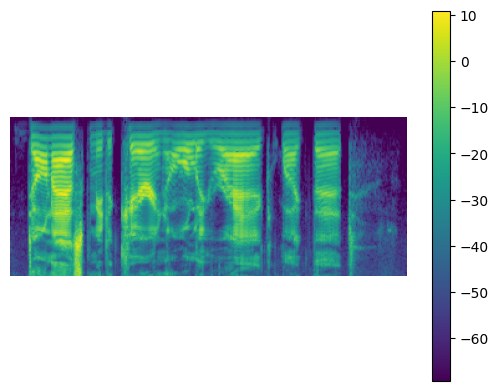

In [50]:
im = plt.imshow(melspec_db[0])
plt.axis('off')
plt.colorbar(im)
plt.show()

In [25]:
display(Audio(waveform.numpy()[0], rate=sample_rate))

In [26]:
# Add noise
noise = torch.randn_like(waveform) * 0.005
noisy_waveform = noise + waveform
display(Audio(noisy_waveform.numpy()[0], rate=sample_rate))

In [27]:
# Random speed up or slow down
stretch_waveform, new_time = AT.Speed(16000, np.random.uniform(0.7,1.3))(waveform)
display(Audio(stretch_waveform.numpy()[0], rate=sample_rate))

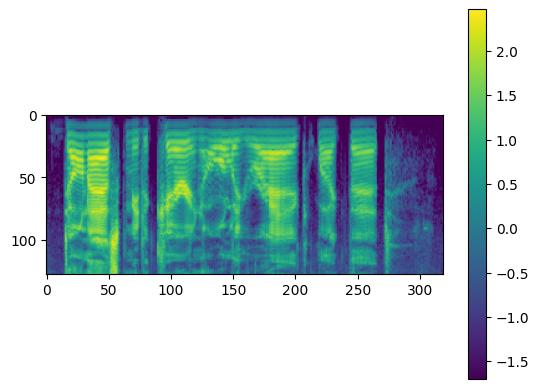

In [51]:
melspec_db_norm = VT.Normalize([melspec_db.mean()], [melspec_db.std()])(melspec_db)
plt.imshow(melspec_db_norm[0])
plt.colorbar()

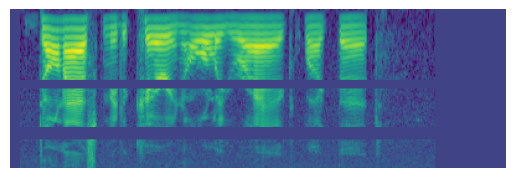

In [55]:
randspeed = VT.Lambda(lambda waveform: AT.Speed(16000, round(random.uniform(0.8,1.2), 2))(waveform)[0])
InjectNoise = VT.Lambda(lambda waveform: waveform + torch.randn_like(waveform) * 0.0005)

AugmentWaveform = VT.Compose([
    randspeed,
    InjectNoise
])

MelSpectrogram = AT.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=2048,
    n_mels=n_mels,
    win_length=400, # 25ms
    hop_length=160, #10ms
)

toSpectrogram = VT.Compose([
    MelSpectrogram,
    AT.AmplitudeToDB(top_db=80), 
])

FreqMasking = torchaudio.transforms.FrequencyMasking(freq_mask_param=20, iid_masks=True)
TimeMasking = torchaudio.transforms.TimeMasking(time_mask_param=30, iid_masks=True)
AugmentSpectrogram = VT.Compose([
    FreqMasking,
    FreqMasking,
])

transform = VT.Compose([
    AugmentWaveform,
    toSpectrogram,
    VT.Normalize([melspec_db.mean()],[melspec_db.std()]),
    VT.RandomCrop((n_mels, 400), pad_if_needed=True),
    AugmentSpectrogram,
])

plt.axis('off')
plt.imshow(transform(waveform)[0])